<a href="https://colab.research.google.com/github/Archarlie2000/CS450-Team/blob/main/Module_5_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting things Read

In [4]:
# Load data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers 
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.metrics import accuracy_score



# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Unzipping files...
Merging training data...
Cleaning up...
Data ready.
Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
training_dir = '/content/training/'
image_size = (100, 100)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [6]:
true = pd.read_csv('test_classes_partial.csv')

from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)


Found 201 images belonging to 1 classes.


# Model


In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = 'Vanila.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath = filepath, 
                             monitor= "val_loss",
                             verbose = 1, 
                             save_best_only = True,
                             mode = "min")




In [ ]:
#Model Structure
model2 = tf.keras.applications.inception_v3.InceptionV3(
    include_top = True,
    weights = None,
    input_tensor = None,
    input_shape = None,
    pooling = None,
    classes = 43,
    classifier_activation='softmax'
)

#Unfroze model
for layer in model2.layers: 
  layer.trainable = True

#Compilation
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
history = model2.fit(train_generator, validation_data = validation_generator, epochs = 20, callbacks = checkpoint)

#Print Result
probabilities = model2.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
print(accuracy_score(true["ClassId"], predictions))

#Save model
model2.save("/content/drive/MyDrive/Inception_V3_Candidate03")



Epoch 1/20
981/981 [==============================] - ETA: 0s - loss: 2.6832 - accuracy: 0.2879
Epoch 1: val_loss improved from inf to 102.69926, saving model to Vanila.epoch01-loss102.70.hdf5
981/981 [==============================] - 87s 81ms/step - loss: 2.6832 - accuracy: 0.2879 - val_loss: 102.6993 - val_accuracy: 0.1829
Epoch 2/20
981/981 [==============================] - ETA: 0s - loss: 1.4076 - accuracy: 0.5757
Epoch 2: val_loss improved from 102.69926 to 1.38868, saving model to Vanila.epoch02-loss1.39.hdf5
981/981 [==============================] - 77s 79ms/step - loss: 1.4076 - accuracy: 0.5757 - val_loss: 1.3887 - val_accuracy: 0.6966
Epoch 3/20
981/981 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8785
Epoch 3: val_loss improved from 1.38868 to 0.48313, saving model to Vanila.epoch03-loss0.48.hdf5
981/981 [==============================] - 79s 80ms/step - loss: 0.3992 - accuracy: 0.8785 - val_loss: 0.4831 - val_accuracy: 0.8477
Epoch 4/20
981/981

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1, fill_mode = 'reflect'),
        keras.layers.RandomContrast(0.1)
    ]
)

model3 = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(100,100,3),
    pooling=None,
    classes=43,
    classifier_activation = 'softmax'
    )

inputs = tf.keras.Input(shape=(100,100,3))
x = data_augmentation(inputs)
outputs = model3(x)
model3 = keras.Model(inputs, outputs)

model3.trainable = True
for layer in model3.layers:
  layer.trainable=True

# Compile model
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 3)
history = model3.fit(train_generator, validation_data = validation_generator, epochs = 20, callbacks = checkpoint)

#Print Result
probabilities = model3.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
print(accuracy_score(true["ClassId"], predictions))

#Save model
model3.save("/content/drive/MyDrive/InceptionV3_Augmentation_Candidate1")


Epoch 1/20


981/981 [==============================] - ETA: 0s - loss: 2.4753 - accuracy: 0.3218
Epoch 1: val_loss improved from inf to 3632.91357, saving model to my_best_model.epoch01-loss3632.91.hdf5
981/981 [==============================] - 226s 222ms/step - loss: 2.4753 - accuracy: 0.3218 - val_loss: 3632.9136 - val_accuracy: 0.0574
Epoch 2/20
981/981 [==============================] - ETA: 0s - loss: 2.3474 - accuracy: 0.3301
Epoch 2: val_loss improved from 3632.91357 to 2.17789, saving model to my_best_model.epoch02-loss2.18.hdf5
981/981 [==============================] - 217s 221ms/step - loss: 2.3474 - accuracy: 0.3301 - val_loss: 2.1779 - val_accuracy: 0.3516
Epoch 3/20
981/981 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.5449
Epoch 3: val_loss improved from 2.17789 to 1.29496, saving model to my_best_model.epoch03-loss1.29.hdf5
981/981 [==============================] - 217s 221ms/step - loss: 1.3458 - accuracy: 0.5449 - val_loss: 1.2950 - val_accuracy: 0.574

# Producing Imagies


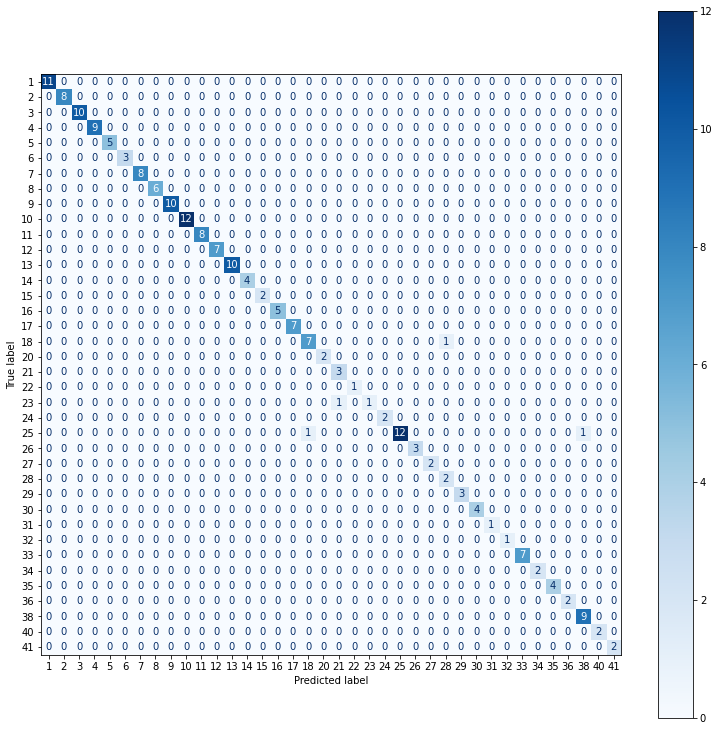

In [ ]:
allclass = true["ClassId"].unique()
allclass.sort()

class_names = allclass

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true["ClassId"], predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels = class_names)
fig, ax = plt.subplots(figsize=(13,13)) # For changing the size of the plot
cmd.plot(ax=ax, cmap="Blues", values_format = '.5g')

In [ ]:
import seaborn as sns

#sns.histplot(data = true, x = "ClassId")

allclass = true["ClassId"].unique()

allclass.sort()
print(allclass)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 38 40 41]


In [12]:
true["ClassId"]

0      16
1       1
2      38
3      33
4      11
       ..
196     8
197    38
198    18
199    28
200    17
Name: ClassId, Length: 201, dtype: int64

In [16]:
import pandas as pd
result = pd.DataFrame()

allclass = true["ClassId"].unique()

allclass.sort()

result["Real label"] = true["ClassId"]
result["Predicted"] = predictions



AttributeError: ignored

In [25]:
k = result["Real label"].value_counts()


25    14
10    12
1     11
3     10
13    10
9     10
38     9
4      9
11     8
18     8
7      8
2      8
33     7
12     7
17     7
8      6
16     5
5      5
14     4
35     4
30     4
21     3
6      3
26     3
29     3
27     2
41     2
40     2
36     2
28     2
20     2
15     2
24     2
23     2
34     2
22     1
32     1
31     1
Name: Real label, dtype: int64

In [14]:
from google.colab import files


result.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
len(predictions3)

12630

# Loading the best model

In [7]:
from keras.models import load_model

In [34]:


model = load_model("/content/my_best_model.epoch18-loss0.07_0.98.hdf5")
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
print(accuracy_score(true["ClassId"], predictions))

7/7 [==============================] - 1s 33ms/step
0.9800995024875622


In [38]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [47]:
print("Precision Score : ", precision_score(true["ClassId"], predictions, 
                                           pos_label='positive',
                                           average='micro'))

print("Recall Score : ", recall_score(true["ClassId"], predictions, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9800995024875622
Recall Score :  0.9800995024875622


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [41]:
p = precision_score(true["ClassId"], predictions, 
                                           pos_label='positive',
                                           average ='micro')


r = recall_score(true["ClassId"], predictions, 
                                           pos_label='positive',
                                           average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [46]:
k = (2*p*r) / (p+r)
k


0.9800995024875622

# Holdout Set


In [26]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

REALtest_datagen = ImageDataGenerator(rescale=1./255)
REALtest_generator = REALtest_datagen.flow_from_directory(
        test_dir,
        classes = ['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)

Found 12630 images belonging to 1 classes.


In [31]:
probabilities2 = model.predict(REALtest_generator)
predictions2 = [np.argmax(probas) for probas in probabilities2]

predictions2

predictions3 = result = pd.DataFrame()
predictions3["First"] = predictions2 

395/395 [==============================] - 11s 28ms/step


In [32]:
predictions3.to_csv('team6-module5-predictions.csv', index=False)